# SOFC Model Development, Mass Action Kinetics
### Lydia Meyer and Rachel Thomas

For our semester project, we will be exploring the transient response capabilities of solid oxide fuel cells (SOFCs), as a function of temperature and pressure.  Our current focus is on deriving the relevant relationships for each current and rendering an operational program blueprint; values shown within are approximate (from HW3) and will require revision upon additional literature reveiw.  This program does not reflect the full complexaties of analyzing transient response, although it breifly explores the impact of temperature and external current variance.

We first break the simulation into the respective half-cell reactions, modeling the global anode reaction only at this time: 
- Anode, $${\rm O^{2-} + \rm H_2 \leftrightharpoons OH^- + \rm H^+ + \rm e^-}$$
$${\rm OH^- + \rm H^+ \leftrightharpoons H_2O + \rm e^-}$$
- Cathode, $${\rm O_2 + \rm 4e^- \leftrightharpoons 2O^{2-}}$$

We will do this using the mass action kinetics form, wihch will eventually allow us to better represent the combined reaction kinetics at the anode:

$$i_{\rm Far} = n_{\rm elec}\rm F \left[k_{fwd}^* \exp\left(\frac{\beta \eta_{elec}F \Delta \phi}{RT}\right)\prod_k C_{ac,k}^{v'} - k_{rev}^* \exp\left(-\frac{\left(1-\beta \right) \eta_{elec}F \Delta \phi}{RT}\right)\prod_k C_{ac,k}^{v''}\right]$$

Assuming fixed gas phase composition and zero transport limitations (i.e. 'flooded cell'), the only state variables are the electric potentials:

- The anode potential, $\phi_{\rm an}$,
- The cathode potential, $\phi_{\rm ca}$, and
- The electrolyte potential, $\phi_{\rm elyte}$,

By assigning the $\phi_{\rm an}$ to a 0V potential, the relative solution vecor is as follows:

$$ SV=\begin{bmatrix} \phi_{\rm elyte} \\ \phi_{\rm ca}\end{bmatrix}$$

The solution vector can be solved via conservation of charge by first calculating the two double-layer voltages, $\Delta\phi_{\rm dl,an}$ and $\Delta\phi_{\rm dl,ca}$, where:
\begin{equation}
\Delta\phi_{\rm dl,an} = \phi_{\rm elyte} - \phi_{\rm an}
\end{equation}
and
\begin{equation}
\Delta\phi_{\rm dl,ca} = \phi_{\rm ca} - \phi_{\rm elyte}
\end{equation}
The solution vector can be then simplified as follows:
$$ SV=\begin{bmatrix} \Delta\phi_{\rm dl,an} \\ \Delta\phi_{\rm dl,ca}\end{bmatrix}$$

Because we're only modeling the anode for this first submittal, the solution vector will actuatly only include $\Delta\phi_{\rm dl,ca}$
$$ SV=\begin{bmatrix} \Delta\phi_{\rm dl,an}\end{bmatrix}$$ 

In [24]:
from scipy.integrate import solve_ivp
import numpy as np
from matplotlib import pyplot as plt
from math import exp, log

# Given Values:
F = 96485e3    # Faraday's constant, C/kmol equivalent charge
R = 8314.5     # Gas constant, J/kmol-K

k_fwd_star = 4.16307062e+7 # Chemical forward rate constant, m^4/kmol^2/s

C_elyte = 46.05    # Total (reference) elyte concentration, kmol/m3
C_Ni_s = 2.6e-08   # Total (reference) concentration of Ni surface sites, kmol/m2

X_H_Ni = 0.6
X_H2O_Ni = 0.2
X_Vac_Ni = 0.2
X_Vac_elyte = 0.08
X_Ox_elyte = 0.92

"Species standard-state thermo"
g_H_Ni_o = -7.109209e+07      # standard-state gibbs energy for H adsorbed on Ni surface (J/kmol)
g_H2O_Ni_o = -3.97403035e+08  # standard-state gibbs energy for H2O adsorbed on Ni surface (J/kmol)
g_Vac_Ni_o = 0.0              # standard-state gibbs energy for Ni surface vacancy (J/kmol)
g_Vac_elyte_o = 0.0           # standard-state gibbs energy for electrolyte oxide vacancy (J/kmol)
g_Ox_elyte_o = -2.1392135e+08 # standard-state gibbs energy for electrolyte oxide O2- (J/kmol)

In [25]:
Beta = 0.5
n = -2
delta_Phi_eq_an = 0.61
DeltaG_rxn_circ = g_Vac_Ni_o + g_H2O_Ni_o + g_Vac_elyte_o - 2*g_H_Ni_o - g_Ox_elyte_o
Prod_C_ac = (X_Vac_elyte*X_H2O_Ni*X_Vac_Ni)/(X_Ox_elyte*X_H_Ni**2)
phi_an = 0
phi_elyte_0 = 0.6
temps =np.array([600, 800, 1200])
i_Far_an = np.zeros_like(temps)
                                  
i_ext=20
                                       
SV_0 = [phi_elyte_0 - phi_an]
#SV_0 = np.array([phi_elyte_0 - phi_an, phi_ca_0 - phi_elyte_0])
time_span = np.array([0,1000])
C_dl_an = 1e4 # F/m2

Next, we need a governing equation for each variable.  Given an external current $i_{\rm ext}$, which moves positive charge from cathode to anode, charge neutrality dictates, for the anode:

$$i_{\rm ext} - i_{\rm Far,an} -i_{\rm dl,an} = 0$$

where $i_{\rm Far}$ is charge transfer current from the anode to the electrolyte, and $i_{\rm dl,an}$ is the anode double layer current - positive charge moved to the anode side of the double layer from the anode bulk.  If $i_{\rm ext}$ and $i_{\rm Far}$ are not equal, then $i_{\rm dl}$ changes the double layer potential to bring them in line.  The double layer id modeled as a capacitor, where:

$$C_{\rm dl,an} = \frac{Q_{\rm dl,.an}}{\Delta \phi_{\rm dl,an}}$$

if we rearrange and take the derivative w/r/t time, we get a differntial equation:

$$\frac{\partial \Delta\phi_{\rm dl,an}}{\partial t} = \frac{dQ_{\rm dl,an}}{dt}\frac{1}{C_{\rm dl,an}} = \frac{i_{\rm dl,an}}{C_{\rm dl,an}}$$

with

$$i_{\rm dl,an} = i_{\rm ext} - i_{\rm Far,an}$$

Simiarly, we can derive for the cathode:

$$\frac{\partial \Delta\phi_{\rm dl,ca}}{\partial t} = \frac{i_{\rm dl,ca}}{C_{\rm dl,ca}}$$

where 

$$i_{\rm dl,ca} = i_{\rm ext} - i_{\rm Far,ca}.$$

Once again, the cathode reactions will be analyzed in greater detial in future revisions.

In [ ]:
def residual(t,SV):
    dSV_dt = np.zeros_like(SV)
    delta_phi = SV[0] - delta_Phi_eq_an
    k_fwd = k_fwd_star * exp(-Beta * n * F * delta_phi / (R * T)) #we need to recalc delta phi
    k_rev = k_rev_star * exp((1-Beta) * n * F * delta_phi / (R * T))
    i_Far_an = n * F * (k_fwd * (X_Ox_elyte*C_elyte*(X_H_Ni*C_Ni_s)**2)
                               - k_rev * (X_Vac_elyte*C_elyte*X_H2O_Ni*C_Ni_s*X_Vac_Ni*C_Ni_s))
    
    i_dl_an = i_ext - i_Far_an
    dSV_dt[0] = -i_dl_an/C_dl_an
    
    # print(i_dl_an)
    # print(dSV_dt)
    return dSV_dt,

### Case 1: vary temp

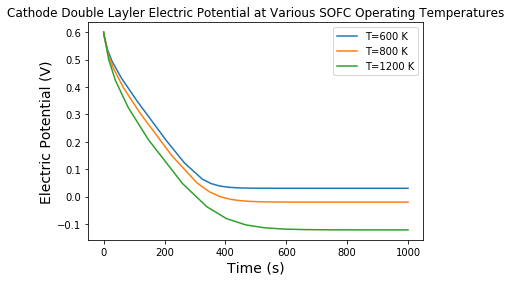

In [29]:
for T in temps:
    DeltaG_rxn = DeltaG_rxn_circ + R*T*log(Prod_C_ac)
    k_rev_star = k_fwd_star / exp(-DeltaG_rxn/(R*T)) / Prod_C_ac
    solution = solve_ivp(residual,time_span,SV_0,rtol=1e-4, atol=1e-6)
    # print(i_Far_an)

    f1=solution.t
    f2=np.transpose(solution.y)
    plt.plot(f1,f2)
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Electric Potential (V)',fontsize=14)
plt.legend(['T=600 K','T=800 K','T=1200 K'])
plt.title('Cathode Double Layer Electric Potential at Various SOFC Operating Temperatures')
plt.show()

The trend is this graph is expexcted such that at each operating temperature, a constant double layer electric potential is reached.  Furhter, it is logical that the rate of change of the double layer potential is greatest (ie largest magnitude slope) for the highest temperature SOFC as the kinetics are faster with increased temperatures.  The time is takes to reach equilibrium is greater than we expected, however true kinetics will be analyzed once the assumed constants are improved.  The plot shown is the solution vector, $\Delta\phi_{\rm dl,ca}$, which is equivalent to the electrolyte electric potential as the anode is assumed to be 0V. 

### Case 2: Vary external current

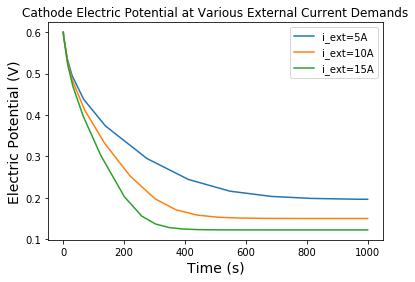

In [27]:
T=800
i_ext_array=np.array([5, 10, 15])
for i_ext in i_ext_array:
    solution = solve_ivp(residual,time_span,SV_0,rtol=1e-4, atol=1e-6)

    f1=solution.t
    f2=np.transpose(solution.y)
    plt.plot(f1,f2)
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Electric Potential (V)',fontsize=14)
plt.legend(['i_ext=5A','i_ext=10A','i_ext=15A'])
plt.title('Cathode Double Layer Electric Potential at Various External Current Demands')

plt.show()

Similalry, this plot shows that the SOFC will reach a stead state equilibrium independent of the assumed external current.  Furthermore, increased external current results in faster kinetics and a increased transient response but results in a lower cathodic double layer electric potential.

Future editions will focus on definiting proper input variables and constants, as well as deriving metrics to analyze transient response capabilities.